# Deep Convolutional Generative Adversarial Network (DCGAN)

### Step 1 - Import libraries

In [160]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 


# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator


# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

Tensorflow/Keras: 2.7.0
numpy: 1.21.4
sklearn: 1.0.1
OpenCV: 4.5.5
matplotlib: 3.5.1
graphviz: 0.19.1


### Step 2 - Load and Process Caltech101 image dataset
- Source and Licence: http://www.vision.caltech.edu/Image_Datasets/Caltech101/
- Required Refrence: L. Fei-Fei, R. Fergus and P. Perona. Learning generative visual models from few training examples: an incremental Bayesian approach tested on 101 object categories. IEEE. CVPR 2004, Workshop on Generative-Model Based Vision. 2004

In [161]:
# Specify the location of images after you have downloaded them
ImgLocation=main_dir+"/data/101_ObjectCategories/"

# List image categories we are interested in (We will only use "bonsai" this time)
CATEGORIES = set(["bonsai"])

# Create a list to store image paths
ImagePaths=[]
for category in CATEGORIES:
    for image in list(os.listdir(ImgLocation+category)):
        ImagePaths=ImagePaths+[ImgLocation+category+"/"+image]
        
# Load images and resize to 64 x 64
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    data_lowres.append(image_lowres)
    
# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = np.array(data_lowres, dtype="float") / 255.0

# Show data shape
print("Shape of data_lowres: ", data_lowres.shape)

Shape of data_lowres:  (128, 64, 64, 3)


##### Display a few real images (64 x 64 pixels)

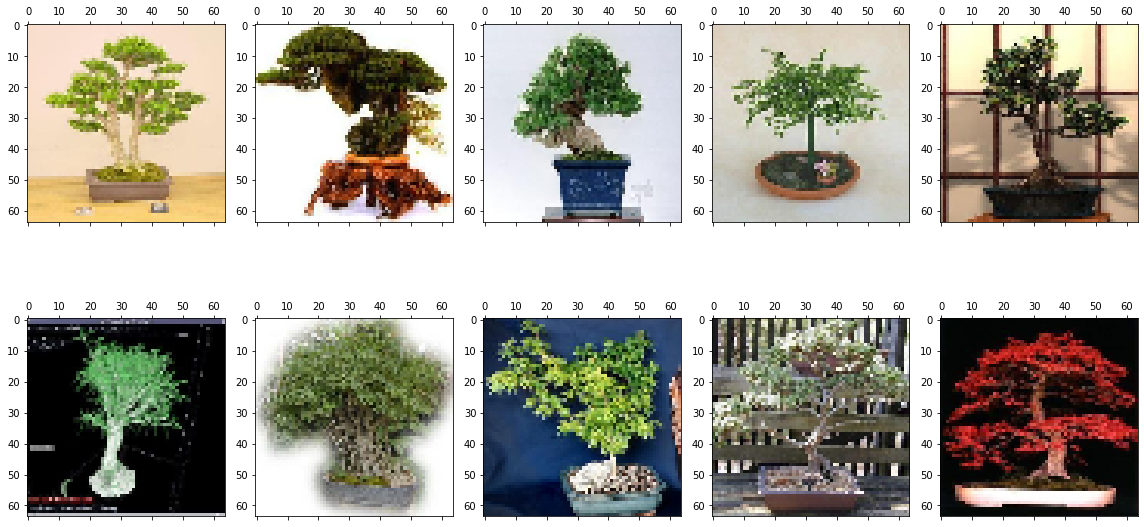

In [163]:
# Display 10 real images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(data_lowres[n])
        n=n+1
plt.show() 

In [164]:
# Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))

# Select images that we want to use fro model trainng
data=data_lowres.copy()
print("Original shape of the data: ", data.shape)

# Reshape array
data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)

# Fit the scaler
scaler.fit(data)

# Scale the array
data=scaler.transform(data)

# Reshape back to the original shape
data=data.reshape(data_lowres.shape[0], 64, 64, 3)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (128, 64, 64, 3)
Reshaped data:  (1572864, 1)
Shape of the scaled array:  (128, 64, 64, 3)


### Step 3 - Setup GAN

#### Define Generator model

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 8192)             827392    
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-Resh  (None, 8, 8, 128)        0         
 ape-1 (Reshape)                                                 
                                                                 
 Generator-Hidden-Layer-2 (C  (None, 16, 16, 128)      262272    
 onv2DTranspose)                                                 
                                                                 
 Generator-Hidden-Layer-Acti  (None, 16, 16, 128)      0         
 vation-2 (ReLU)                                                 
                                                                 
 Generator-Hidden-Layer-3 (C  (None, 32, 32, 256)      52

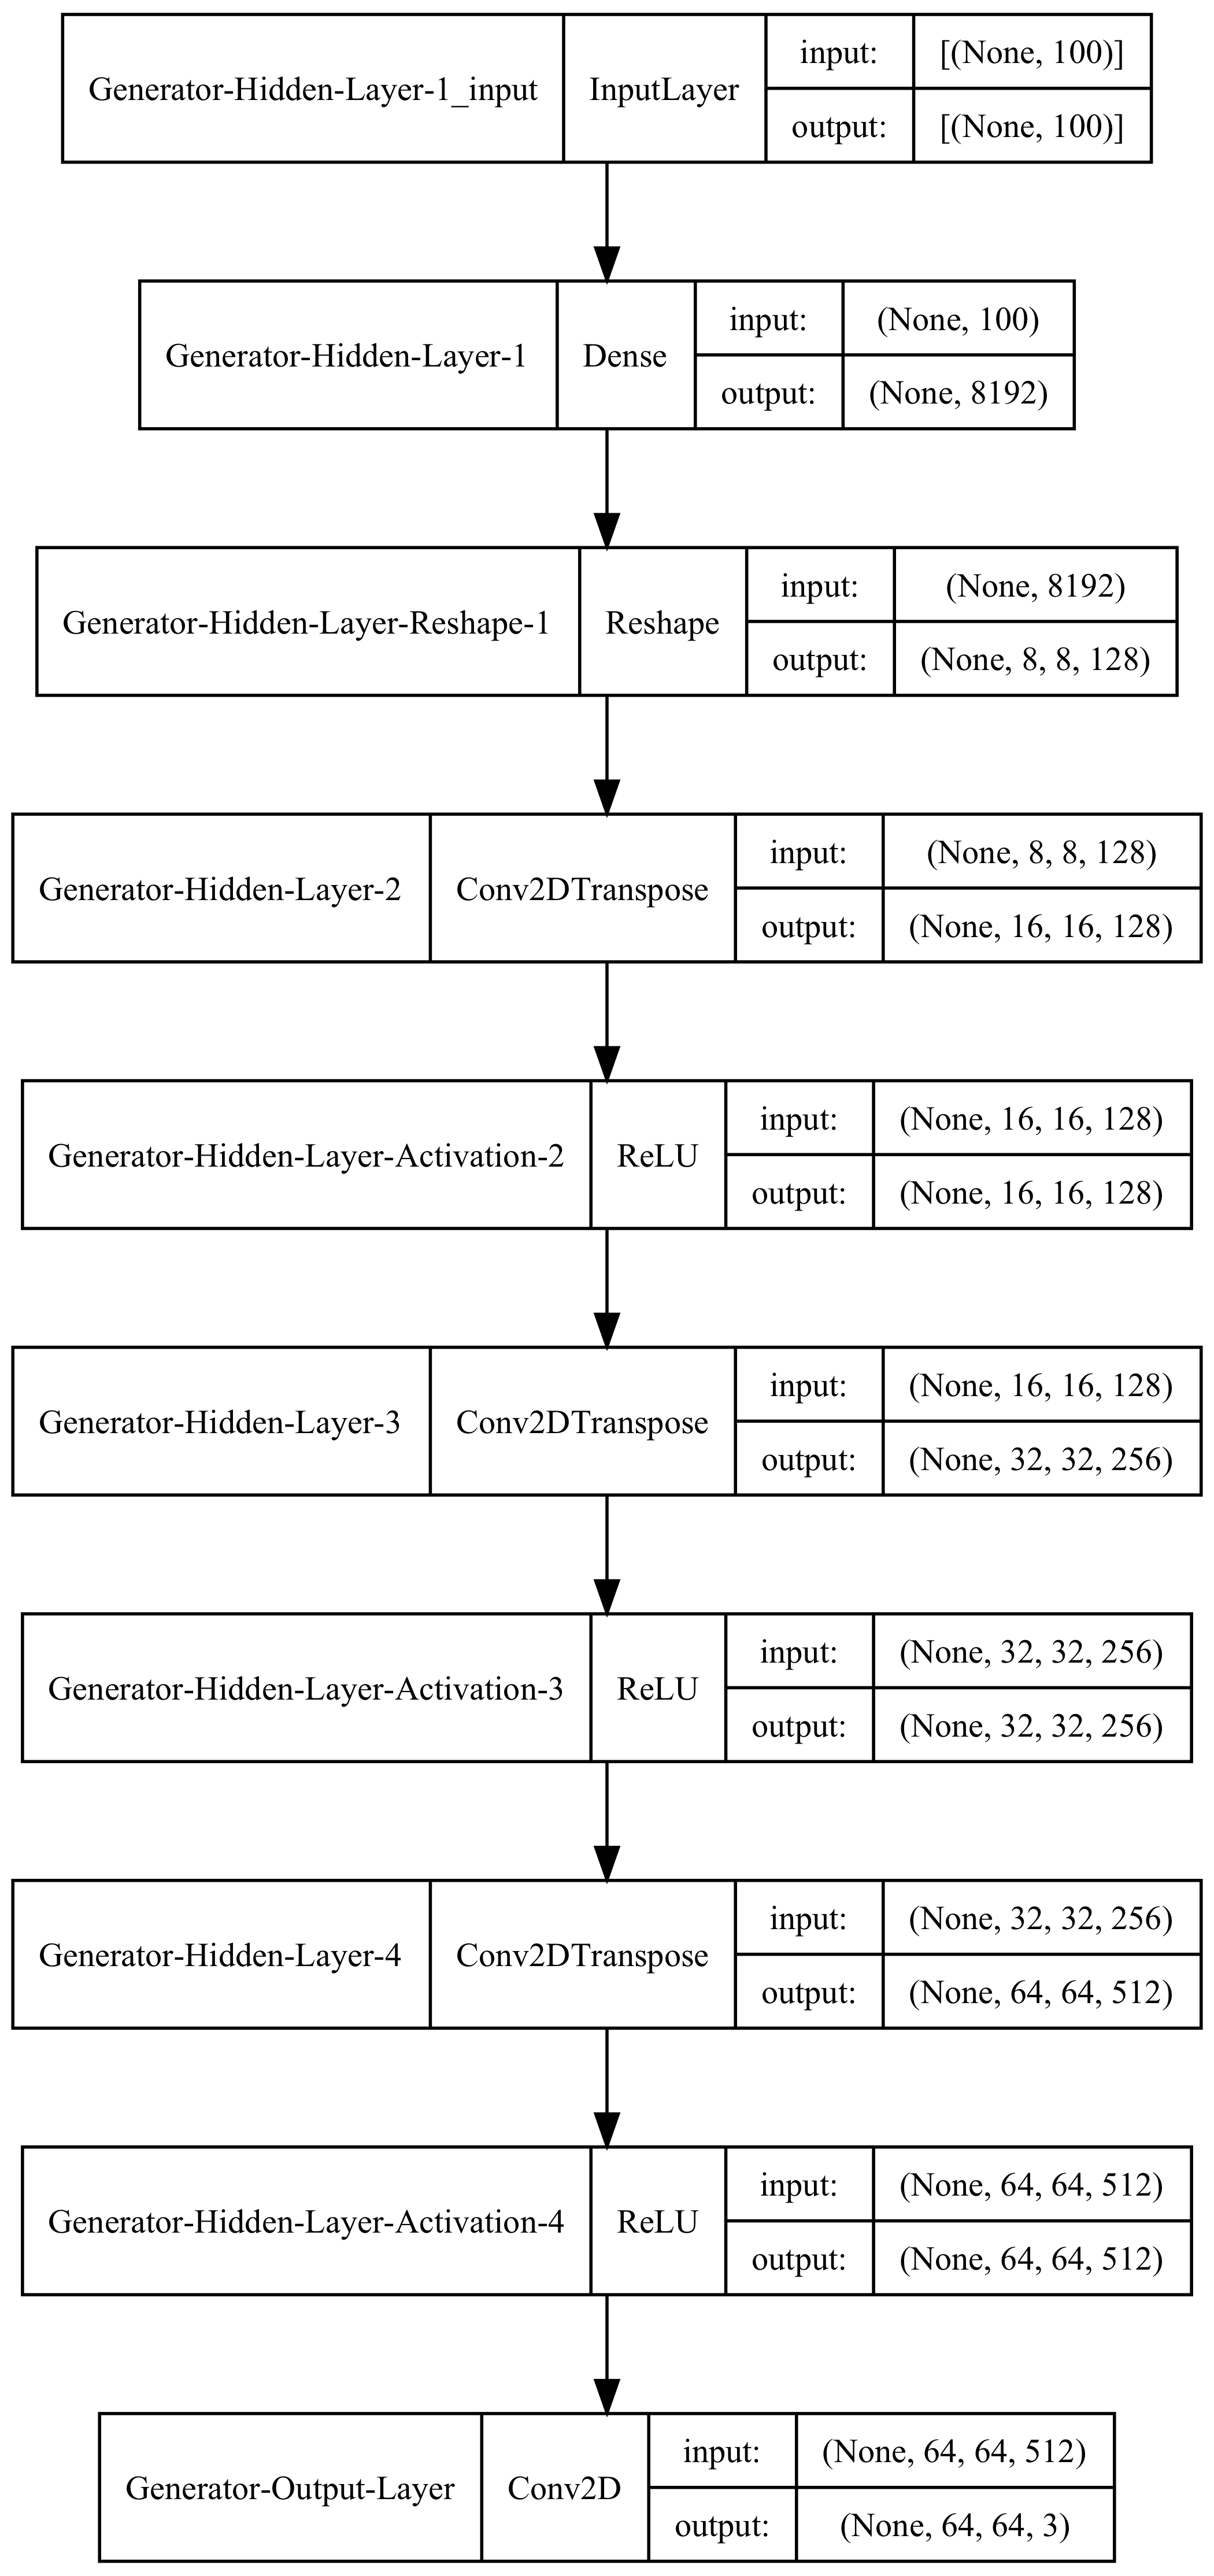

In [23]:
def generator(latent_dim):
    model = Sequential(name="Generator") # Model
    
    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))
    
    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))
                              
    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))
    
    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))
    
    # Output Layer (Note, we use 3 filters because we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400) #, to_file='generator_structure.png')

#### Define a Discriminator model

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       3136      
 1 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       0         
 Activation-1 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      131200    
 2 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      0         
 Activation-2 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 8, 8, 128)      

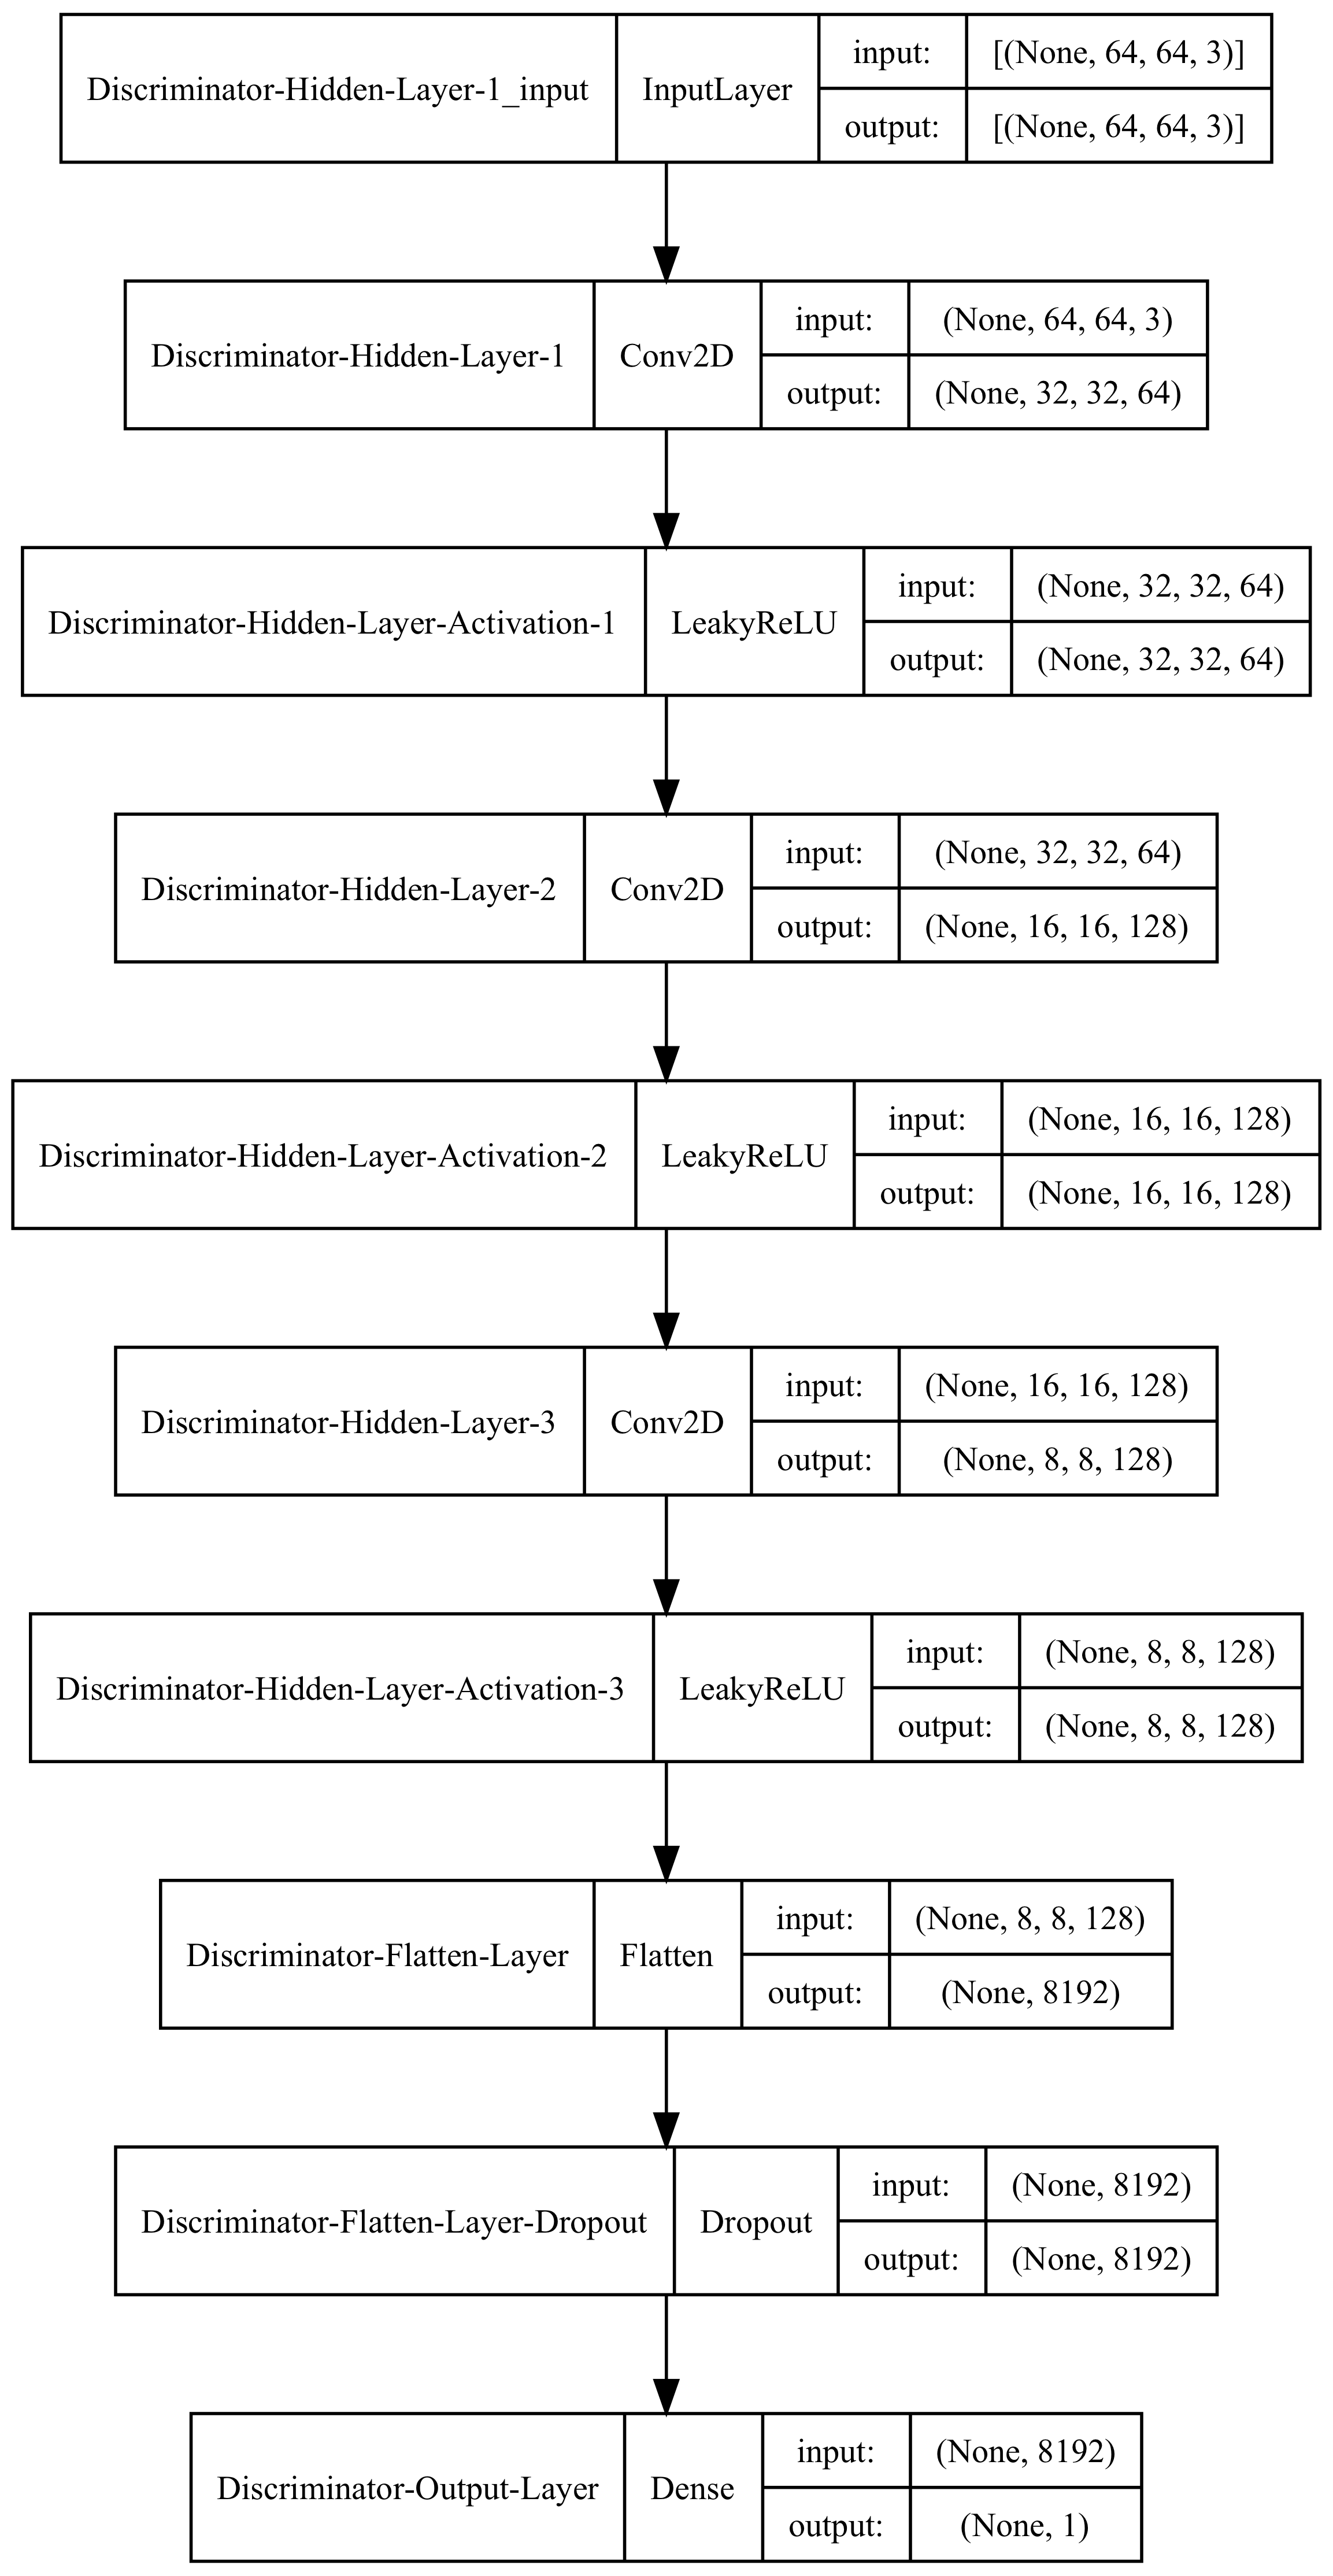

In [24]:
def discriminator(in_shape=(64,64,3)):
    model = Sequential(name="Discriminator") # Model
    
    # Hidden Layer 1
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    
    # Hidden Layer 2
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
    
    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
    
    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400) #, to_file='discriminator_structure.png')

#### Combine Generator and Discriminator models into trainable GAN

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         3750275   
                                                                 
 Discriminator (Sequential)  (None, 1)                 404801    
                                                                 
Total params: 4,155,076
Trainable params: 3,750,275
Non-trainable params: 404,801
_________________________________________________________________


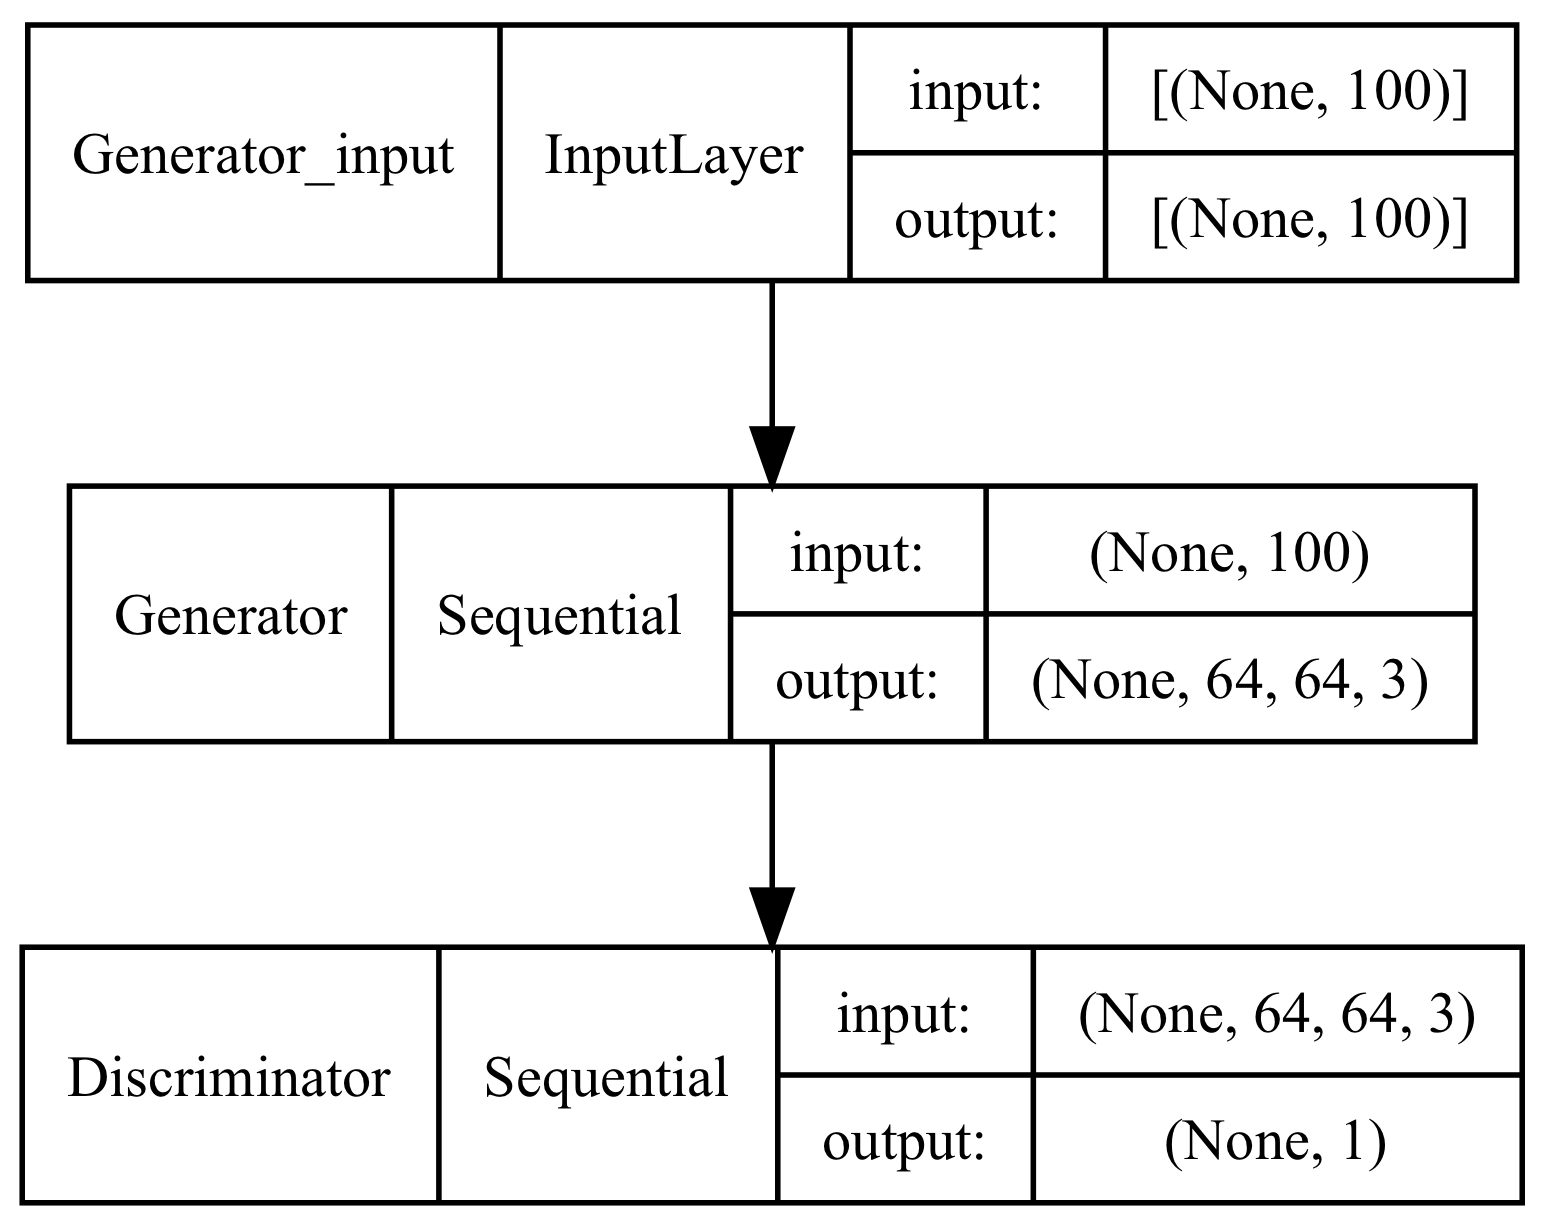

In [25]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400) #, to_file='dcgan_structure.png')

### Step 4 - Setup functions to:
- sample the latent space 
- sample real images
- generate fake images with the generator model

##### Set up a function to sample real images

In [26]:
def real_samples(n, dataset):
    
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))

    return X, y

##### Generate points in the latent space, which we will use as inputs for the generator

In [27]:
def latent_vector(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input

##### The below function will use the generator to generate n fake examples together with class labels

In [28]:
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y

### Step 5 - Setup functions for model performance evaluation and training

##### Show Discriminator model accuracy and plot real vs. fake (generated) comparison

In [29]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Create a 2D scatter plot to show real and fake (generated) data points
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 

##### Define a function to train our DCGAN model (generator and discriminator)

In [30]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1001, n_batch=32, n_eval=100):
    
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

### Step 6 - Train the model and plot the results

##### Use the above train function to train our GAN model

Epoch number:  0
*** Training ***
Discriminator Loss  0.719986617565155
Generator Loss:  0.693274974822998
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.0


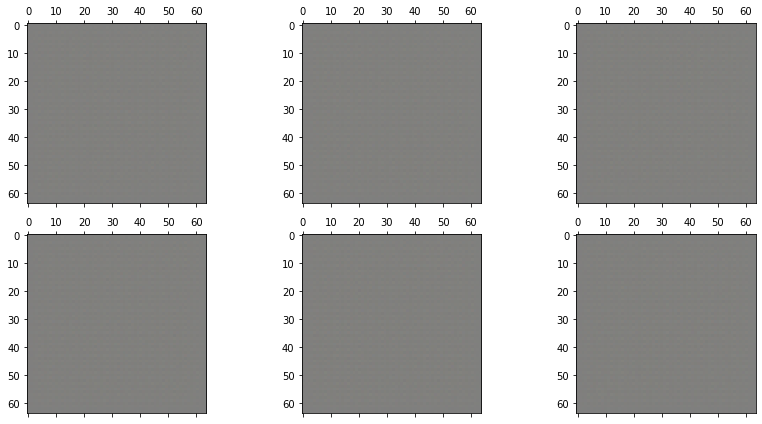

Epoch number:  100
*** Training ***
Discriminator Loss  0.313886821269989
Generator Loss:  3.1102733612060547
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7400000095367432
Discriminator Accuracy on FAKE (generated) images:  1.0


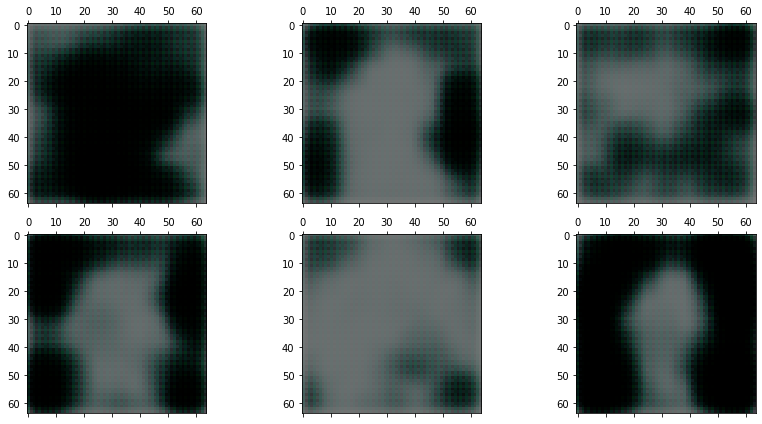

Epoch number:  200
*** Training ***
Discriminator Loss  0.45719248056411743
Generator Loss:  1.134324312210083
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9800000190734863
Discriminator Accuracy on FAKE (generated) images:  0.3799999952316284


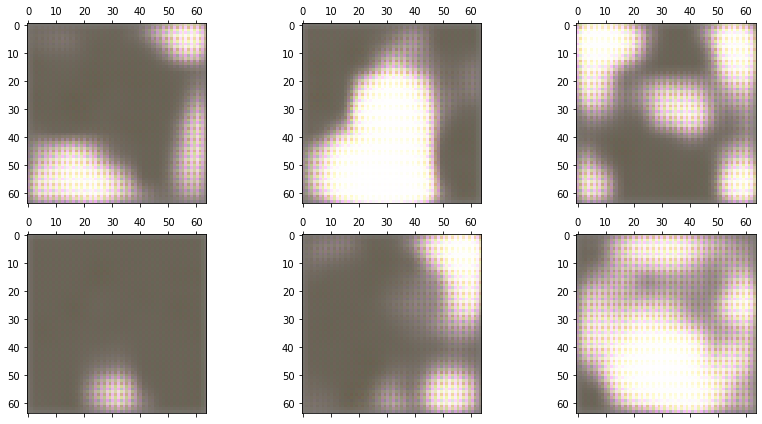

Epoch number:  300
*** Training ***
Discriminator Loss  0.6766767501831055
Generator Loss:  1.1427431106567383
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.4000000059604645
Discriminator Accuracy on FAKE (generated) images:  0.6399999856948853


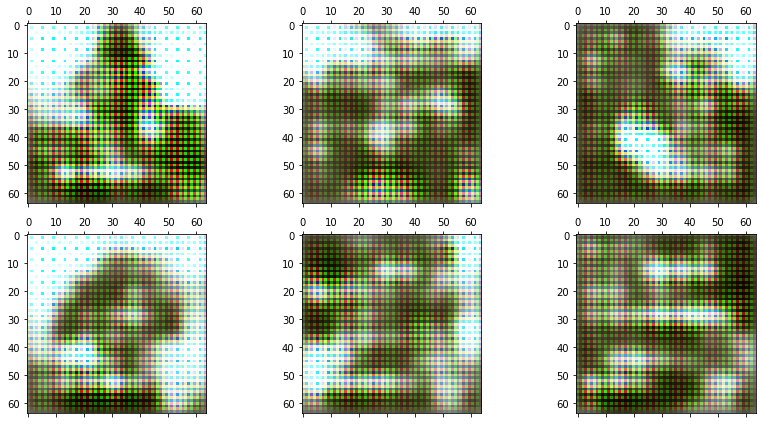

Epoch number:  400
*** Training ***
Discriminator Loss  0.5270434617996216
Generator Loss:  1.8168269395828247
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6000000238418579
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


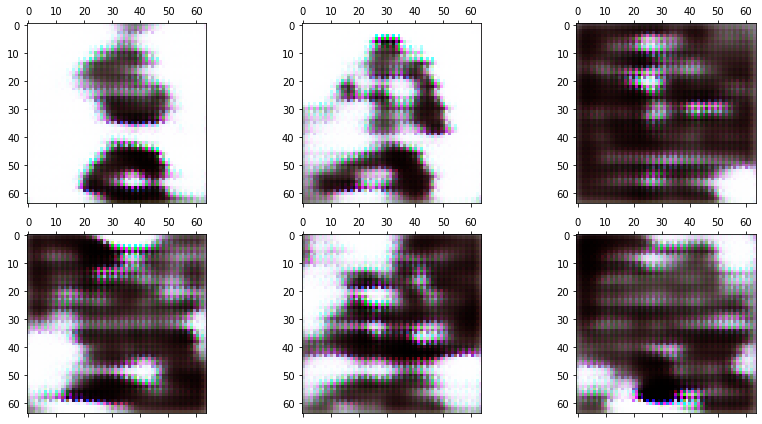

Epoch number:  500
*** Training ***
Discriminator Loss  0.590928316116333
Generator Loss:  1.3518316745758057
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.46000000834465027
Discriminator Accuracy on FAKE (generated) images:  0.699999988079071


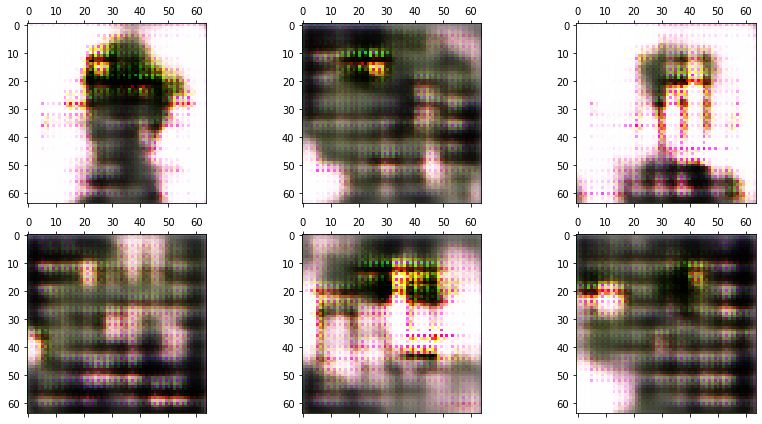

Epoch number:  600
*** Training ***
Discriminator Loss  0.35676681995391846
Generator Loss:  3.410188913345337
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6200000047683716
Discriminator Accuracy on FAKE (generated) images:  0.6399999856948853


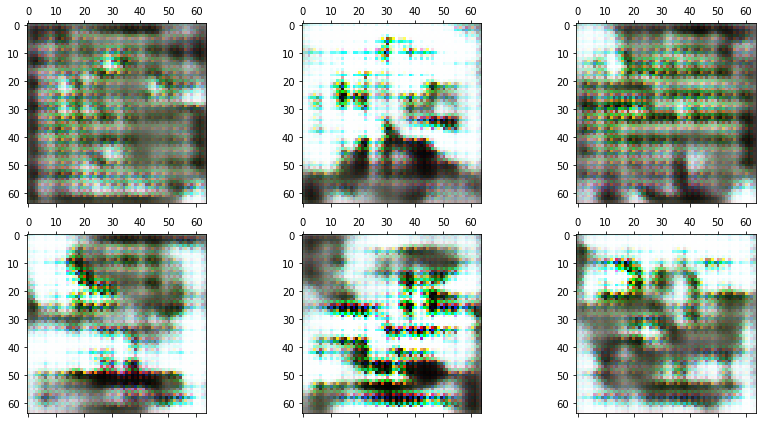

Epoch number:  700
*** Training ***
Discriminator Loss  0.6003313660621643
Generator Loss:  1.177125096321106
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


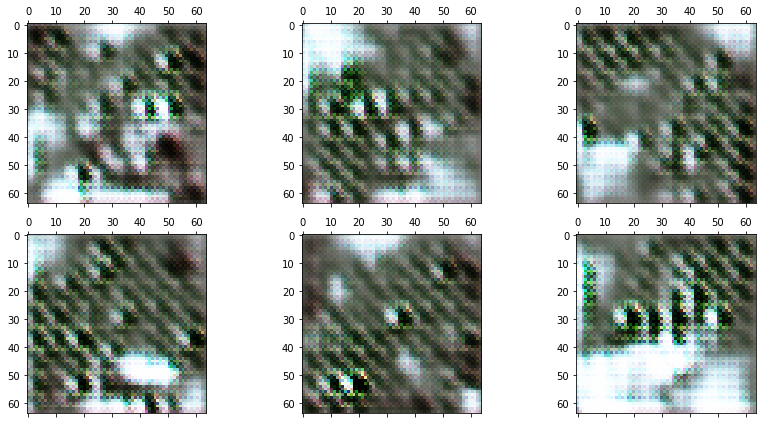

Epoch number:  800
*** Training ***
Discriminator Loss  0.3093014359474182
Generator Loss:  1.6203688383102417
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.8999999761581421


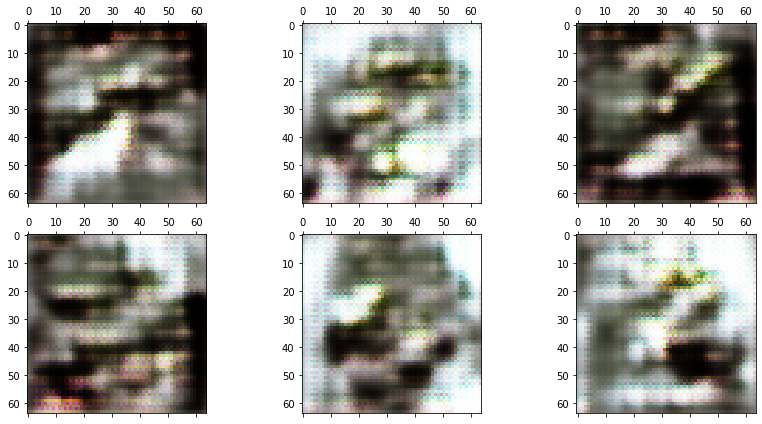

Epoch number:  900
*** Training ***
Discriminator Loss  0.4843713045120239
Generator Loss:  1.176061749458313
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  0.7200000286102295


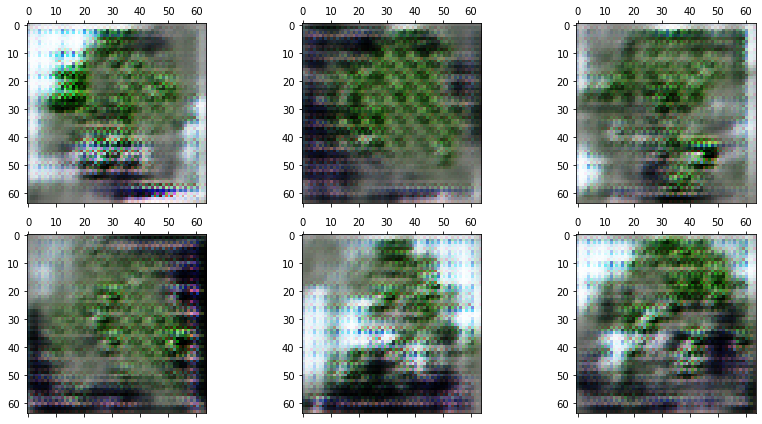

Epoch number:  1000
*** Training ***
Discriminator Loss  0.48319536447525024
Generator Loss:  1.558413028717041
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  0.8999999761581421


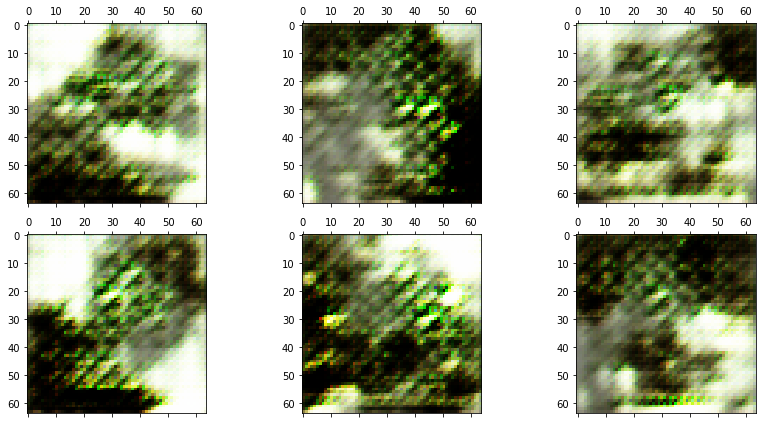

In [31]:
# Train DCGAN model
# 1k epochs
train(gen_model, dis_model, gan_model, data, latent_dim)

Epoch number:  0
*** Training ***
Discriminator Loss  0.46350252628326416
Generator Loss:  1.5335781574249268
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


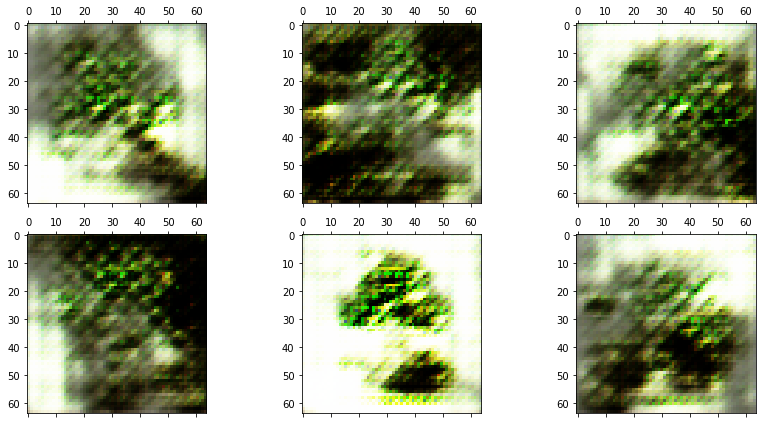

Epoch number:  100
*** Training ***
Discriminator Loss  0.41331565380096436
Generator Loss:  1.6396353244781494
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.800000011920929
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


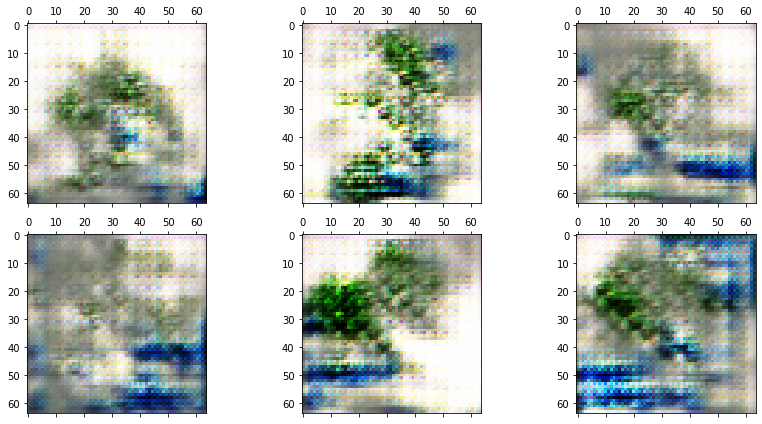

Epoch number:  200
*** Training ***
Discriminator Loss  0.593255877494812
Generator Loss:  1.5645976066589355
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.6800000071525574


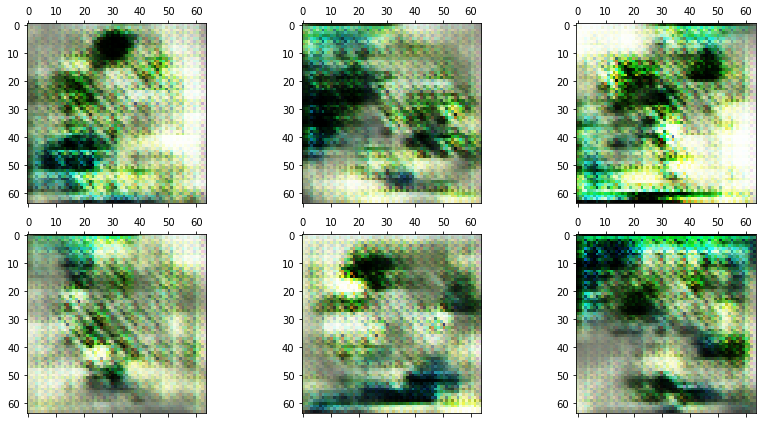

Epoch number:  300
*** Training ***
Discriminator Loss  0.6285778880119324
Generator Loss:  0.8614535331726074
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8399999737739563
Discriminator Accuracy on FAKE (generated) images:  0.47999998927116394


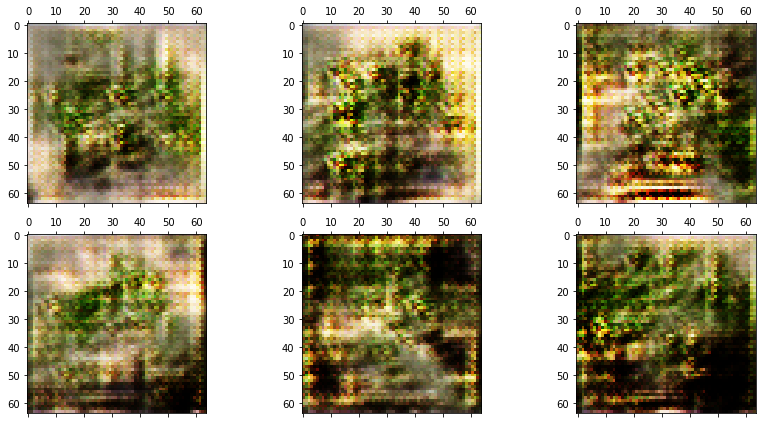

Epoch number:  400
*** Training ***
Discriminator Loss  0.5626323223114014
Generator Loss:  0.9050490856170654
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.800000011920929
Discriminator Accuracy on FAKE (generated) images:  0.8399999737739563


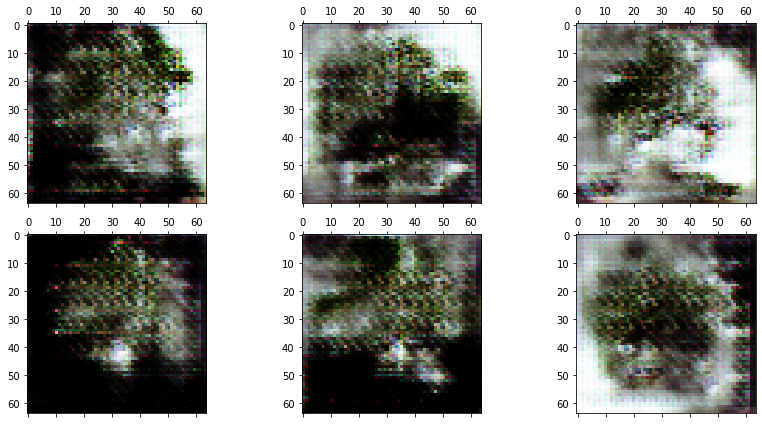

Epoch number:  500
*** Training ***
Discriminator Loss  0.7256777286529541
Generator Loss:  1.0877156257629395
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


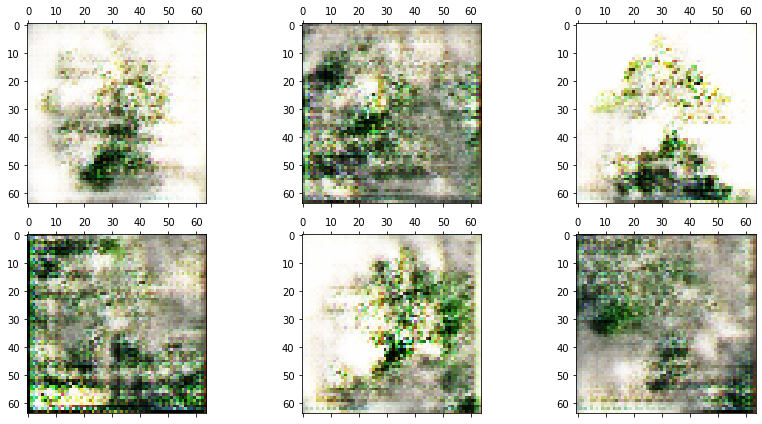

Epoch number:  600
*** Training ***
Discriminator Loss  0.5521504878997803
Generator Loss:  0.9055110216140747
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.7200000286102295


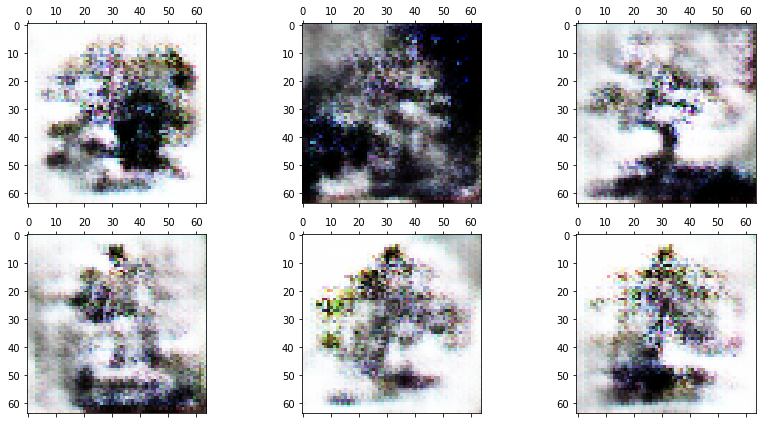

Epoch number:  700
*** Training ***
Discriminator Loss  0.6506883502006531
Generator Loss:  1.1834300756454468
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6399999856948853
Discriminator Accuracy on FAKE (generated) images:  0.7599999904632568


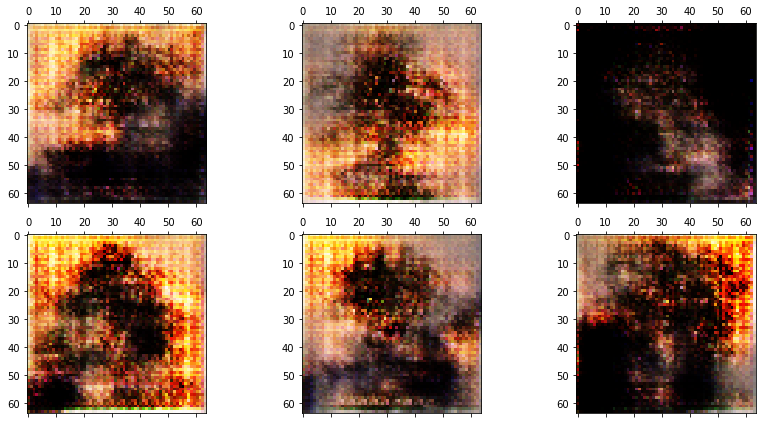

Epoch number:  800
*** Training ***
Discriminator Loss  0.562085747718811
Generator Loss:  0.9894461631774902
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7799999713897705
Discriminator Accuracy on FAKE (generated) images:  0.8799999952316284


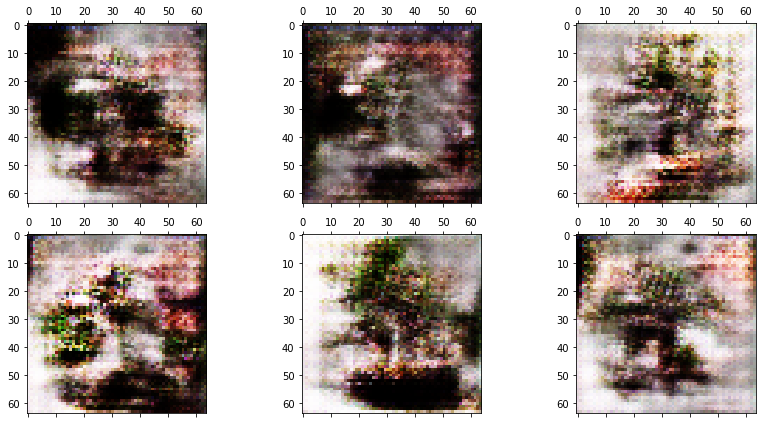

Epoch number:  900
*** Training ***
Discriminator Loss  0.4973224401473999
Generator Loss:  1.149047613143921
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8399999737739563
Discriminator Accuracy on FAKE (generated) images:  0.6200000047683716


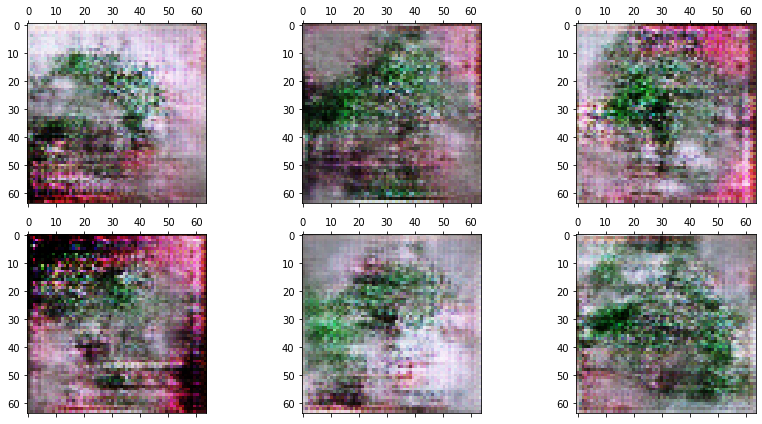

Epoch number:  1000
*** Training ***
Discriminator Loss  0.47596678137779236
Generator Loss:  1.3754184246063232
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.4399999976158142
Discriminator Accuracy on FAKE (generated) images:  1.0


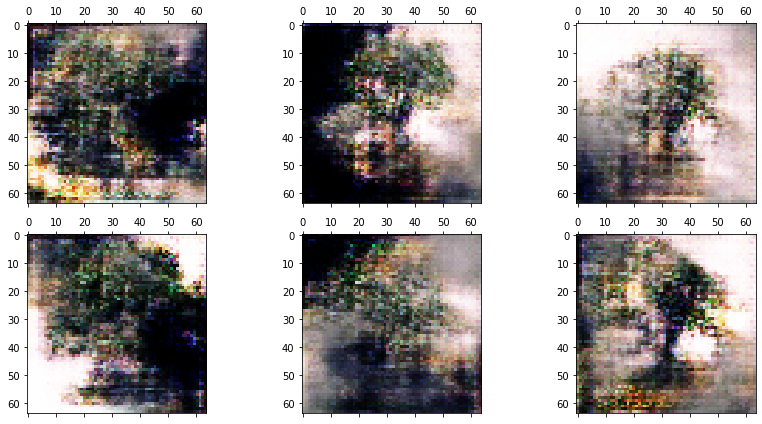

In [32]:
# Continue training DCGAN model for another 1000 epochs (Total: 2K epochs)
train(gen_model, dis_model, gan_model, data, latent_dim)

In [ ]:
# Save the current versions of the models (After 2k epcohs)
gen_model.save(main_dir+"/data/models/007a_Generator_2k.h5")
dis_model.save(main_dir+"/data/models/007a_Discriminator_2k.h5")
gan_model.save(main_dir+"/data/models/007a_GAN_2k.h5")

Epoch number:  0
*** Training ***
Discriminator Loss  0.584968090057373
Generator Loss:  1.107938528060913
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6600000262260437
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


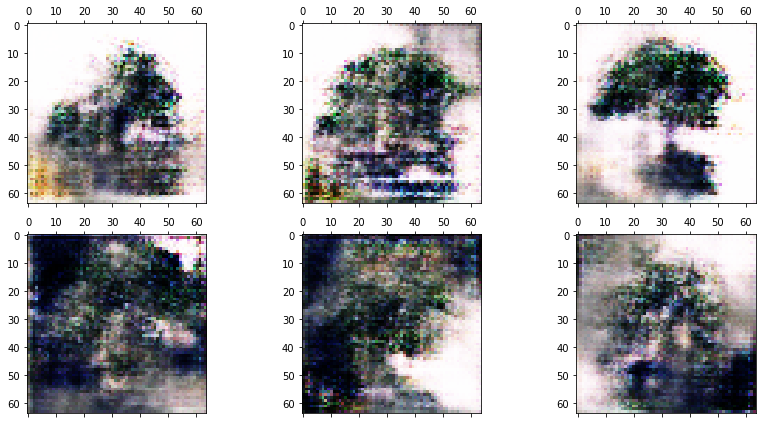

Epoch number:  100
*** Training ***
Discriminator Loss  0.4762645959854126
Generator Loss:  1.0608099699020386
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  1.0


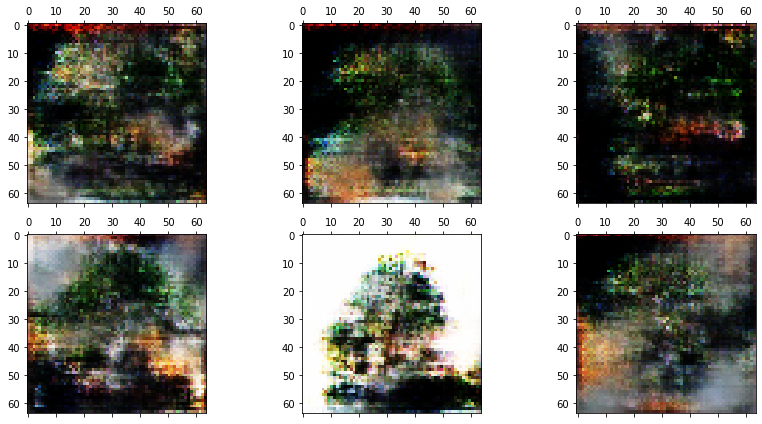

Epoch number:  200
*** Training ***
Discriminator Loss  0.6234560012817383
Generator Loss:  0.8461437821388245
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7799999713897705
Discriminator Accuracy on FAKE (generated) images:  0.6600000262260437


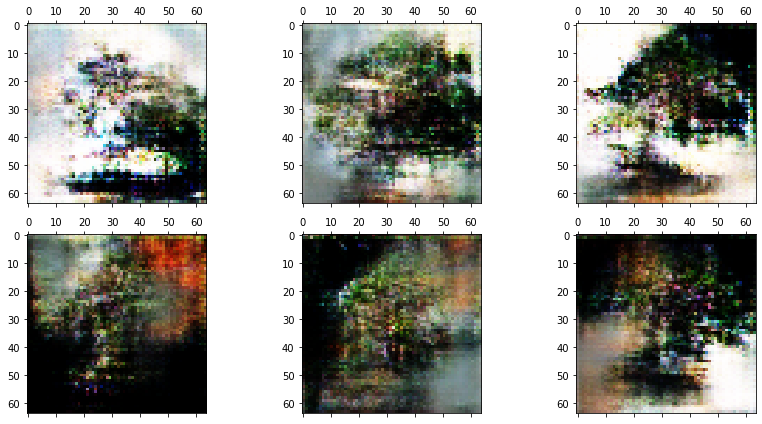

Epoch number:  300
*** Training ***
Discriminator Loss  0.5362727642059326
Generator Loss:  1.4541187286376953
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.41999998688697815
Discriminator Accuracy on FAKE (generated) images:  0.8199999928474426


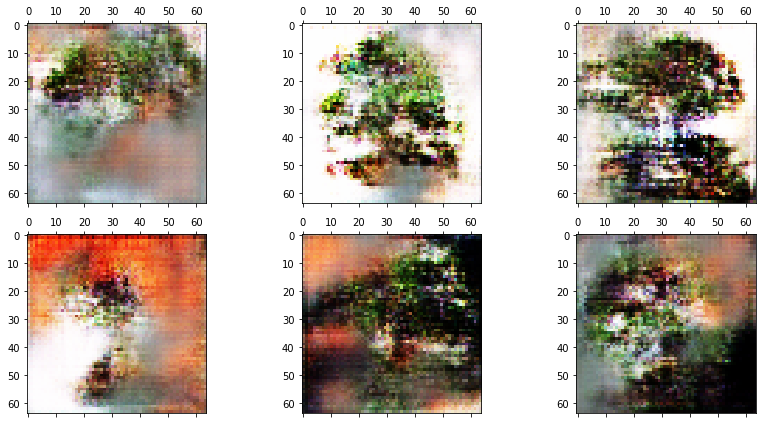

Epoch number:  400
*** Training ***
Discriminator Loss  0.6121505498886108
Generator Loss:  1.0090432167053223
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  0.9200000166893005


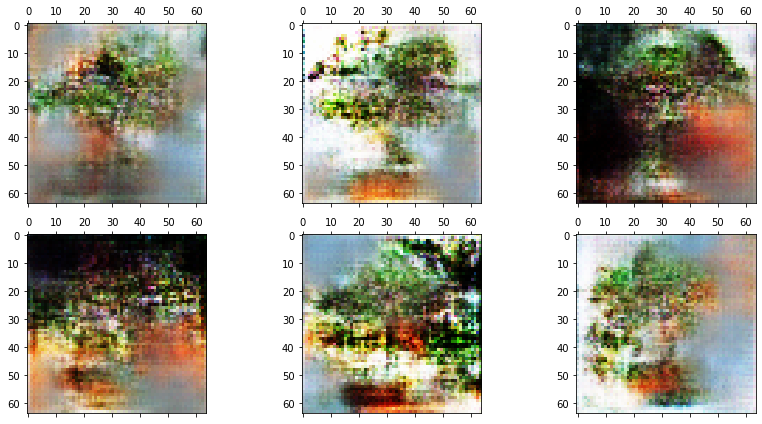

Epoch number:  500
*** Training ***
Discriminator Loss  0.5413137674331665
Generator Loss:  1.0284512042999268
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6000000238418579
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


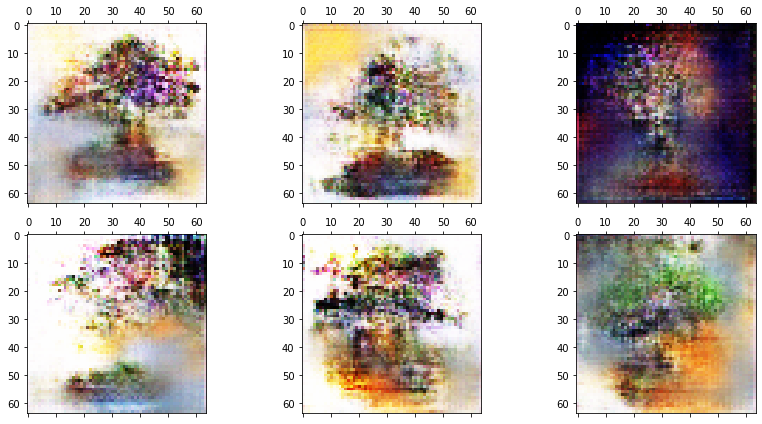

Epoch number:  600
*** Training ***
Discriminator Loss  0.5660308599472046
Generator Loss:  1.1685009002685547
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8799999952316284
Discriminator Accuracy on FAKE (generated) images:  1.0


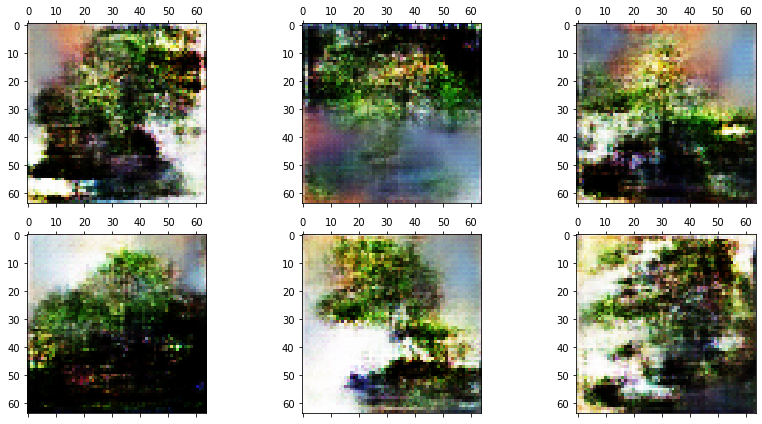

Epoch number:  700
*** Training ***
Discriminator Loss  0.4688805341720581
Generator Loss:  1.0803661346435547
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  0.7599999904632568


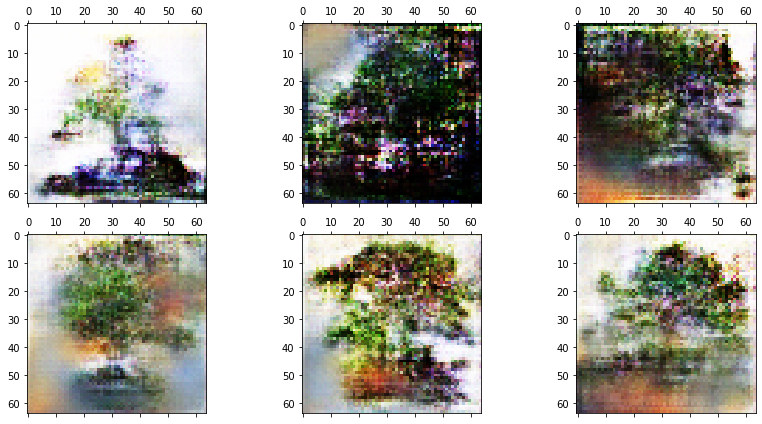

Epoch number:  800
*** Training ***
Discriminator Loss  0.4922812283039093
Generator Loss:  1.0886595249176025
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  0.8799999952316284


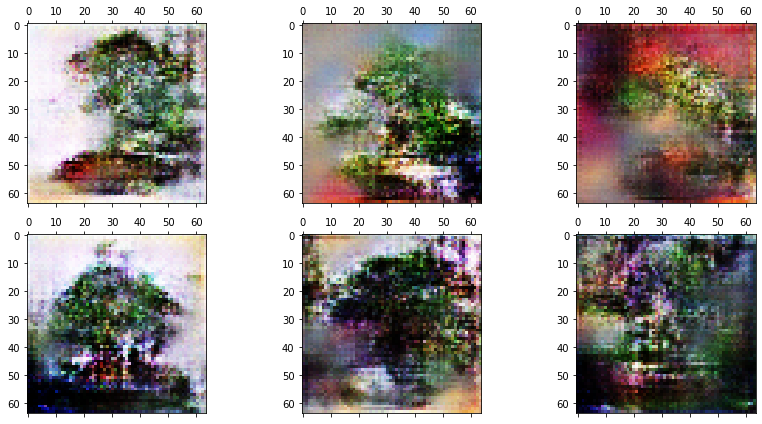

Epoch number:  900
*** Training ***
Discriminator Loss  0.4136659502983093
Generator Loss:  1.2787517309188843
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


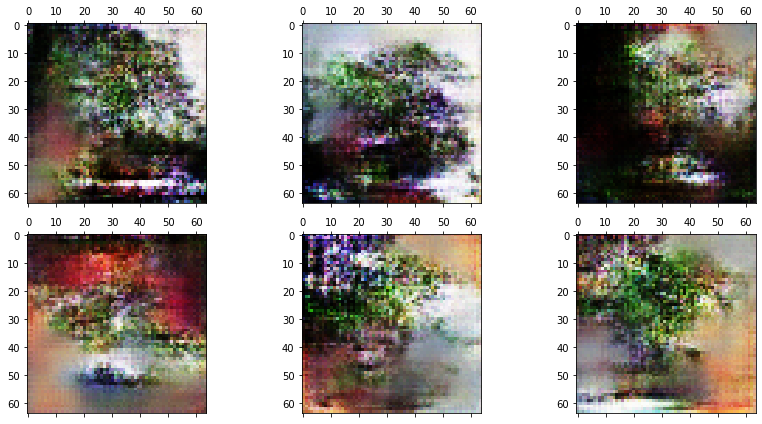

Epoch number:  1000
*** Training ***
Discriminator Loss  0.41352957487106323
Generator Loss:  1.3003017902374268
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9200000166893005
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


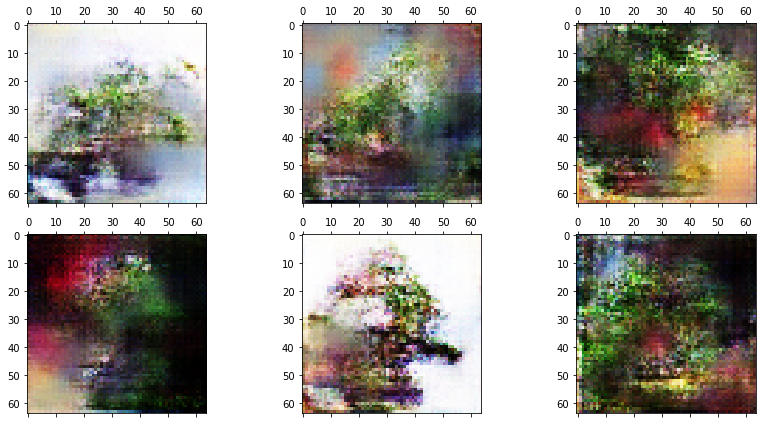

In [36]:
# Continue training DCGAN model for another 1000 epochs (Total: 3K epochs)
train(gen_model, dis_model, gan_model, data, latent_dim)

In [ ]:
# Save the current versions of the models (After 3k epcohs)
gen_model.save(main_dir+"/data/models/007b_Generator_3k.h5")
dis_model.save(main_dir+"/data/models/007b_Discriminator_3k.h5")
gan_model.save(main_dir+"/data/models/007b_GAN_3k.h5")

##### Example how to load a previously saved model

In [ ]:
# Add library
# from keras.models import load_model
# Load saved models
# gen_model = load_model(main_dir+"/data/models/007b_Generator_3k.h5")
# dis_model = load_model(main_dir+"/data/models/007b_Discriminator_3k.h5")
# gan_model = load_model(main_dir+"/data/models/007b_GAN_3k.h5")

---

### Step 7 - Evaluate model performace and use the Generator to create a bunch of images 

In [37]:
def performance_eval(epoch, generator, discriminator, dataset, latent_dim, n=40):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("Epoch number: ", epoch)
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Create a 2D scatter plot to show real and fake (generated) data points
    # Display 20 fake images
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(8, 5, sharey=False, tight_layout=True, figsize=(48,48), facecolor='white')
    k=0
    for i in range(0,8):
        for j in range(0,5):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 

Epoch number:  0
Discriminator Accuracy on REAL images:  0.4749999940395355
Discriminator Accuracy on FAKE (generated) images:  0.925000011920929


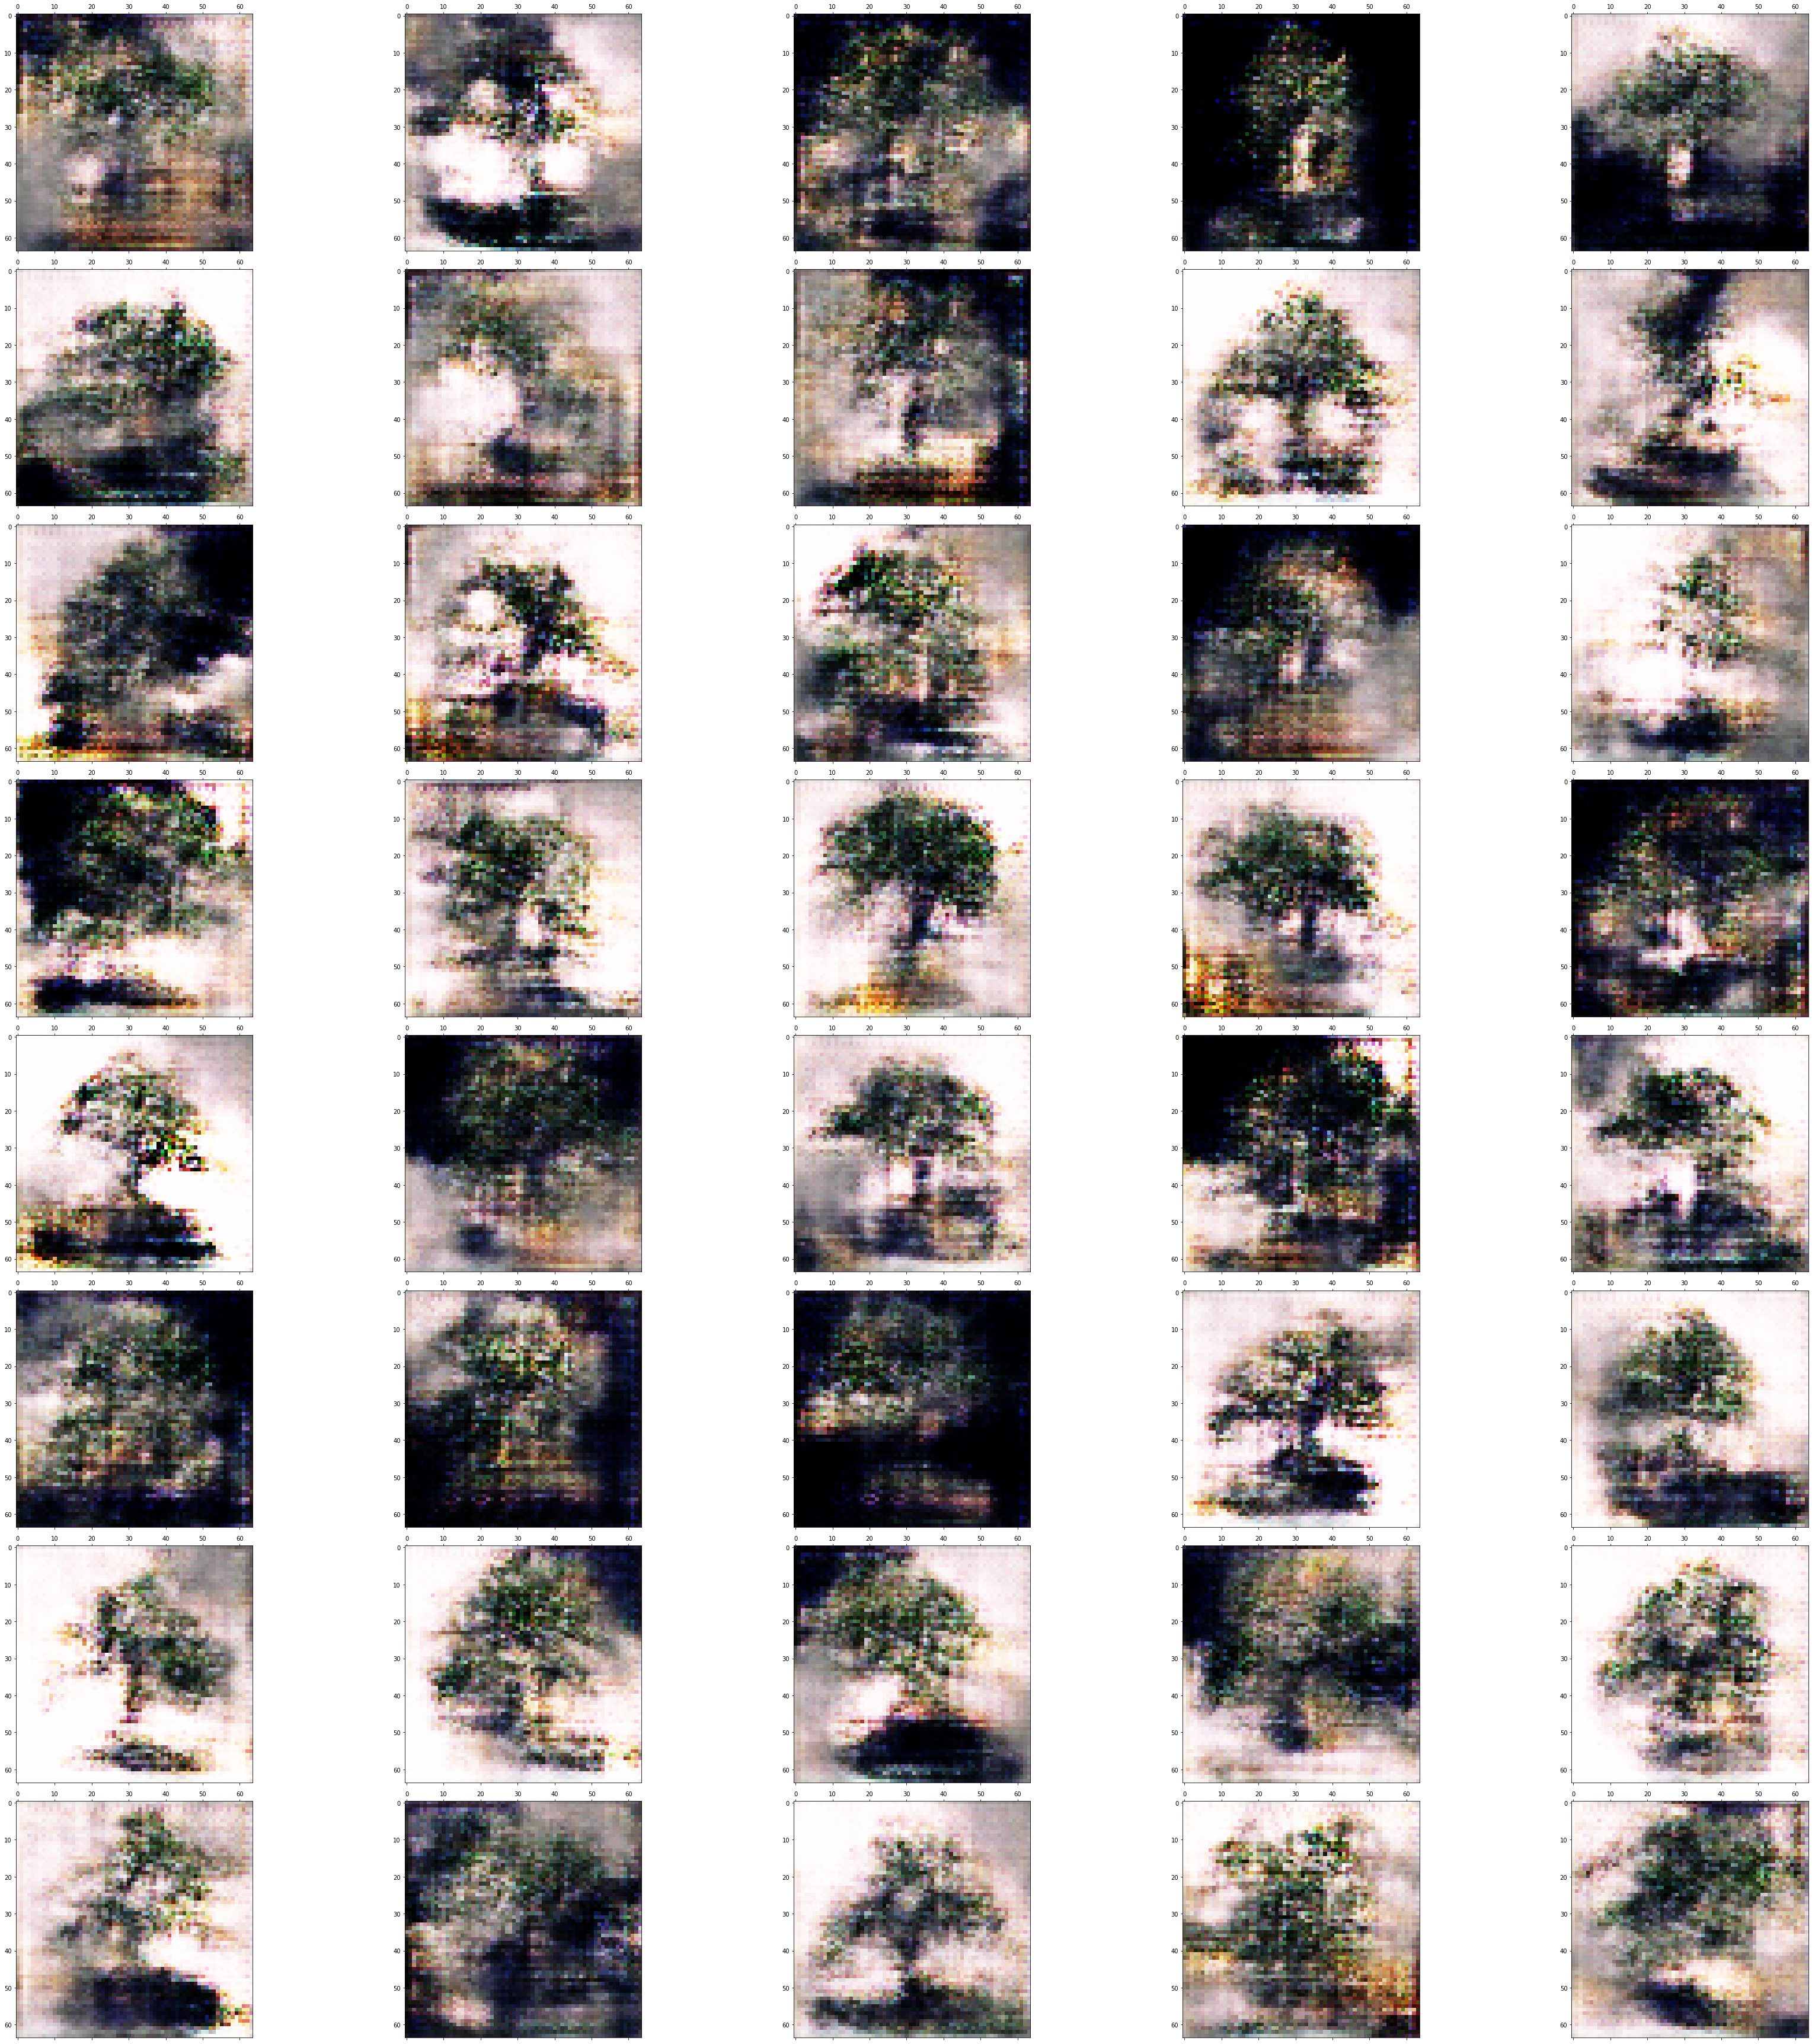

In [34]:
# After 2K epochs
performance_eval(0, gen_model, dis_model, data, 100)

Epoch number:  0
Discriminator Accuracy on REAL images:  0.800000011920929
Discriminator Accuracy on FAKE (generated) images:  1.0


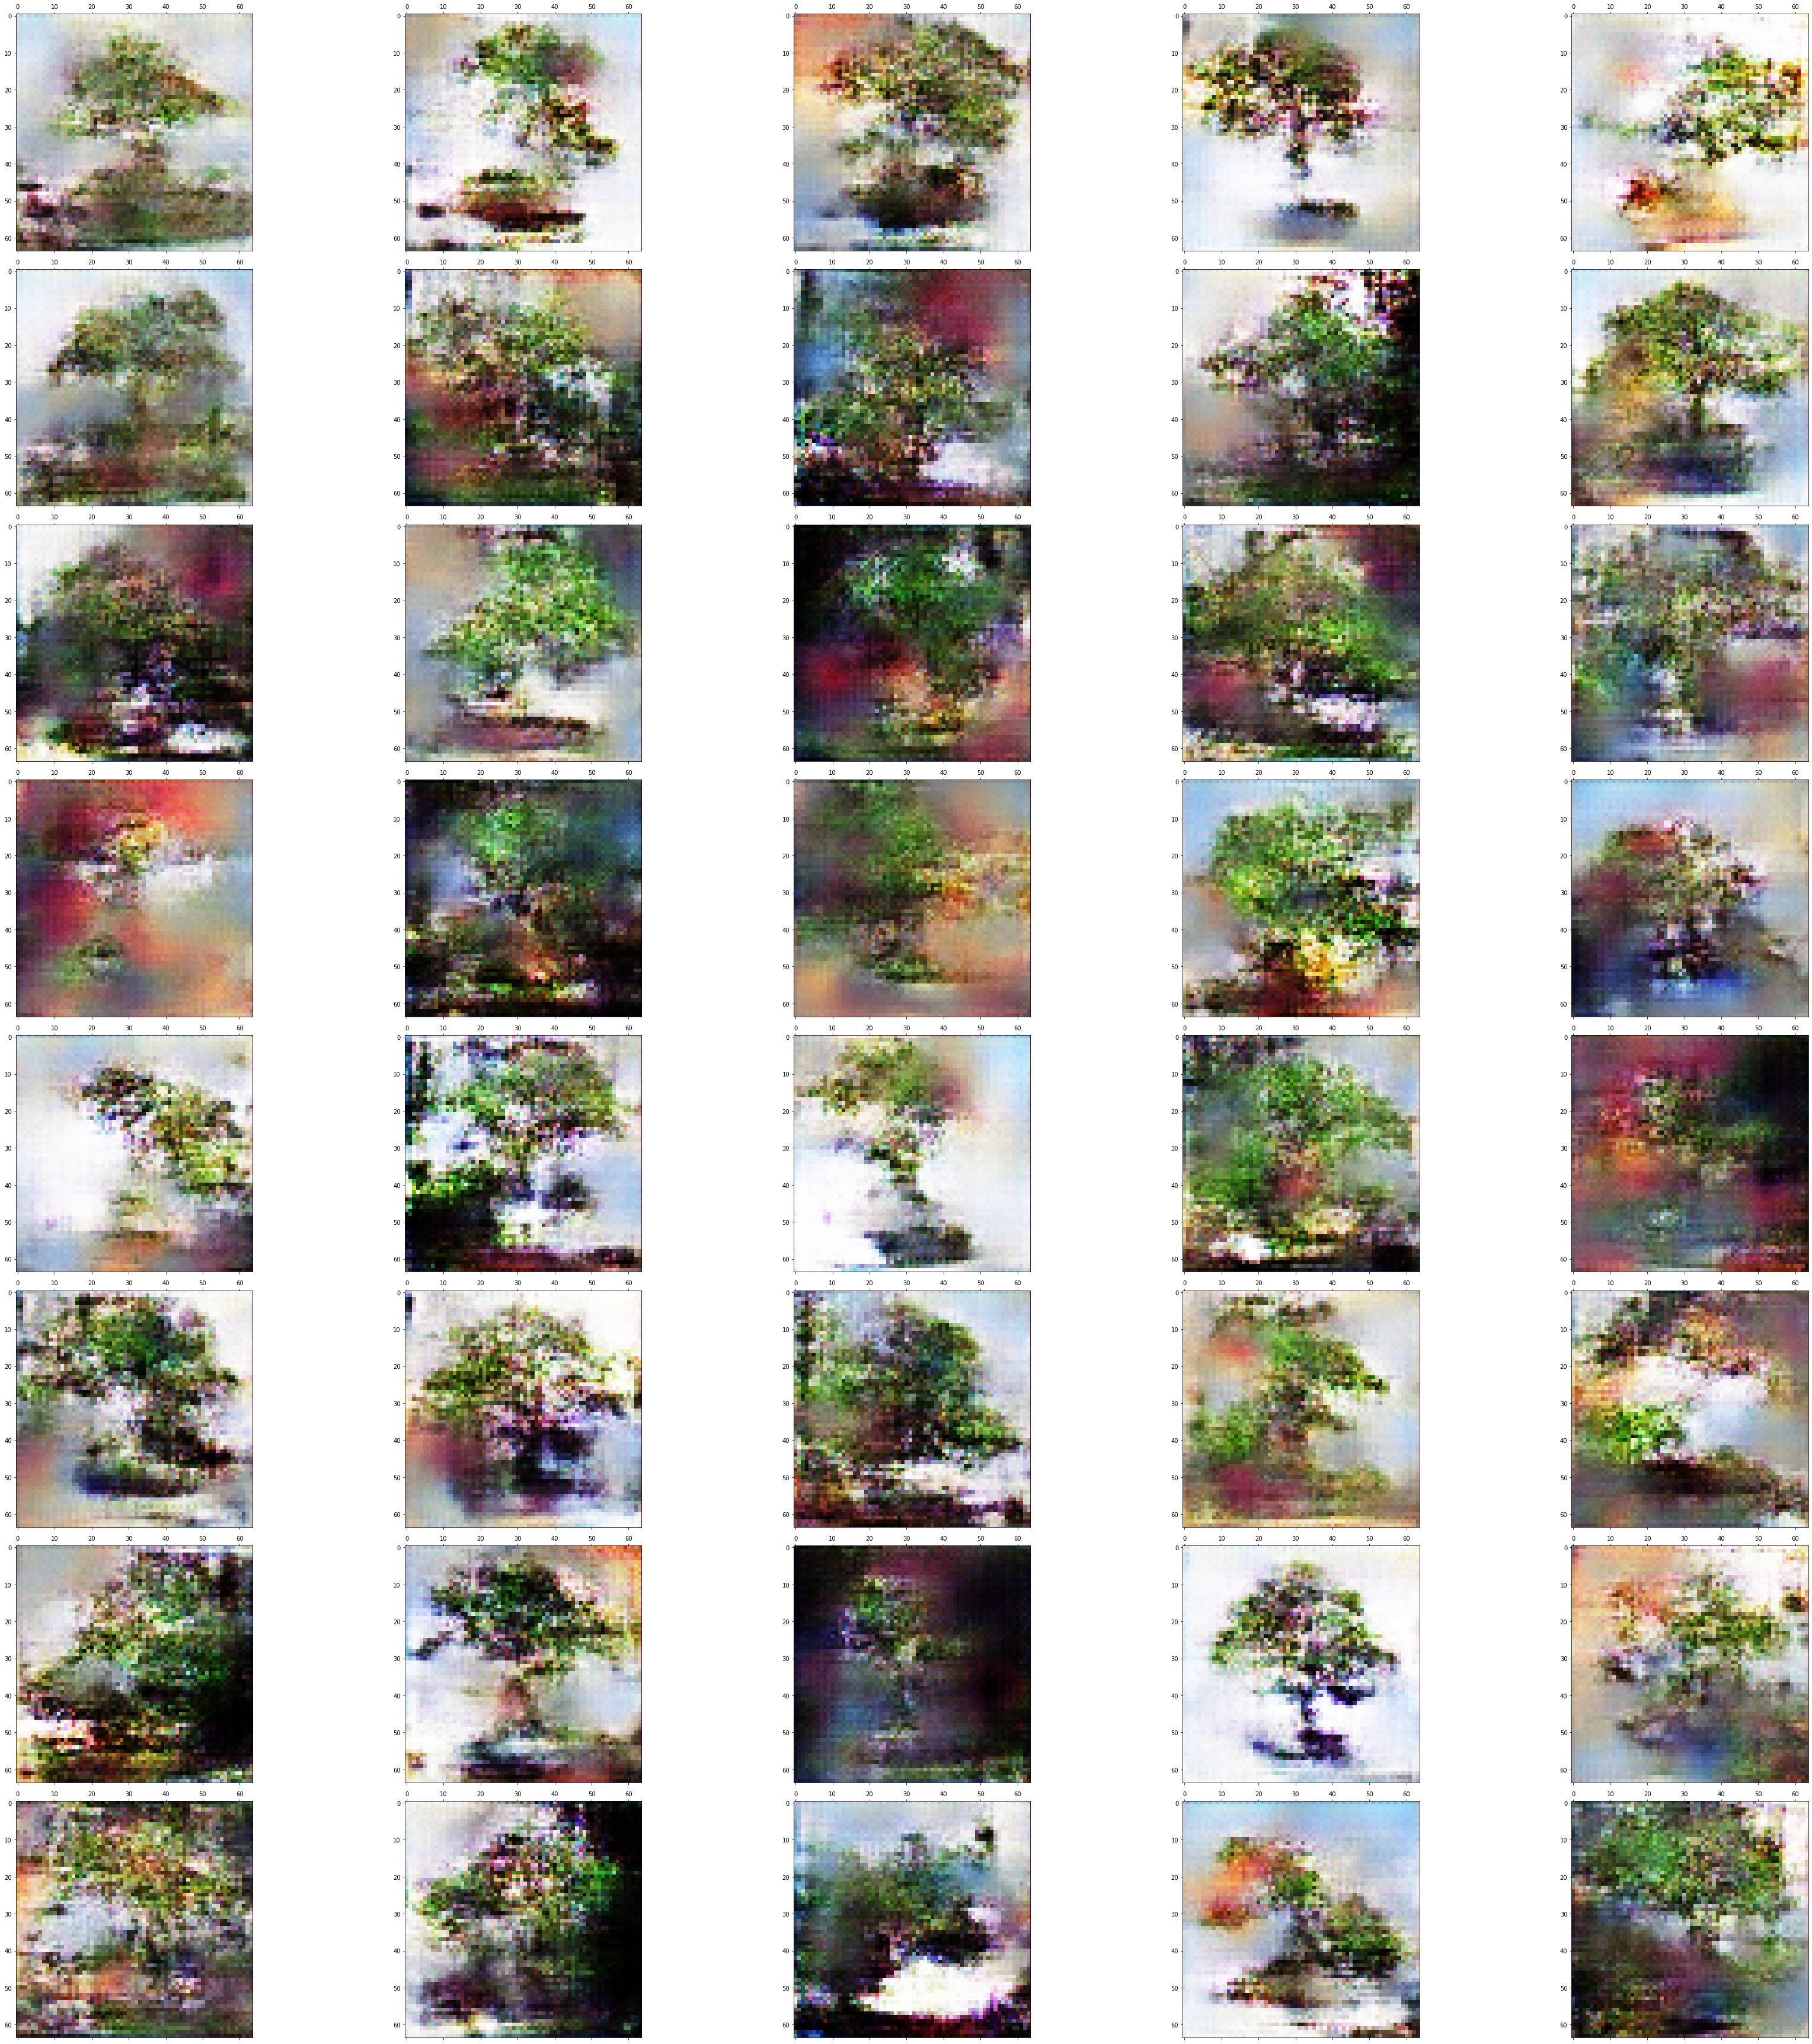

In [38]:
# After 3K epochs
performance_eval(0, gen_model, dis_model, data, 100)

---

### Appendix - Generate one random Image

In [247]:
# Generate an image of a bonsai tree using random latent vector
x_fake, y_fake = fake_samples(gen_model, 100, 1)

# Shape and inverse transpose the generated image
x_fake_inv_trans=x_fake.reshape(-1, 1)
x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
x_fake_inv_trans=x_fake_inv_trans.reshape(64, 64, 3)

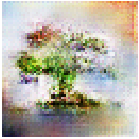

In [248]:
# Show the generated image
fig, ax = plt.subplots(figsize=(16,9), dpi=20)
ax.matshow(x_fake_inv_trans)
plt.axis('off')
plt.show()

# End of Program